In [2]:
# imports

from __future__ import division
import codecs
import json
from itertools import chain, izip, permutations, combinations
from collections import Counter, defaultdict
import ConfigParser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy

from annoy import AnnoyIndex
from nltk.parse import CoreNLPParser
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [4]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

# TODO: Fix path. Add section to config with path to this dir
sys.path.append('/Users/das/work/svn/Gits/p_Public/sempix/Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [5]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['mscoco_bbdf', 'refcoco_refdf', 'refcocoplus_refdf', 'grex_refdf',
            'vgpardf', 'cococapdf']
df = load_dfs(preproc_path, df_names)

# load up pre-computed similarities
coco_sem_sim, coco_sem_map = load_imsim(os.path.join(preproc_path, 'mscoco_sim.npz'))
visg_sem_sim, visg_sem_map = load_imsim(os.path.join(preproc_path, 'visgen_sim.npz'))
coco_id2semsim = invert_dict(coco_sem_map)
visg_id2semsim = invert_dict(visg_sem_map)

coco_vis_sim, coco_vis_map = load_imsim(os.path.join(preproc_path, 'mscoco_vis_sim.npz'))
visg_vis_sim, visg_vis_map = load_imsim(os.path.join(preproc_path, 'visgen_vis_sim.npz'))
coco_id2vissim = invert_dict(coco_vis_map)
visg_id2vissim = invert_dict(visg_vis_map)

A couple of women standing on a tennis court shaking hands.
Two female tennis players shaking hands across the net.
Two women playing tennis are shaking hands over the net.
Two female tennis players shaking hands in front of the referee
Two women shaking hands at a tennis match.


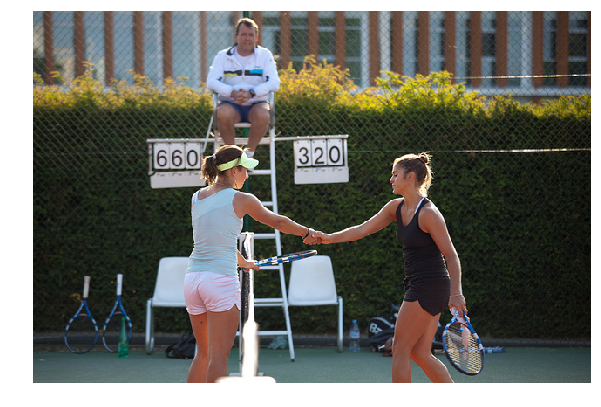

In [15]:
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]
for cap in query_by_id(df['cococapdf'], (ic, ii), 'caption'):
    print cap
plot_labelled_bb(get_image_filename(config, ic, ii), [])

A woman in sandals stands next to clocks.
A woman's feet standing next to four clock faces on a floor.
Four clock plates sit on the brown floor.
Four clock sitting on a floor next to a woman's feet.
There are four clocks laying on the floor near a person's foot.


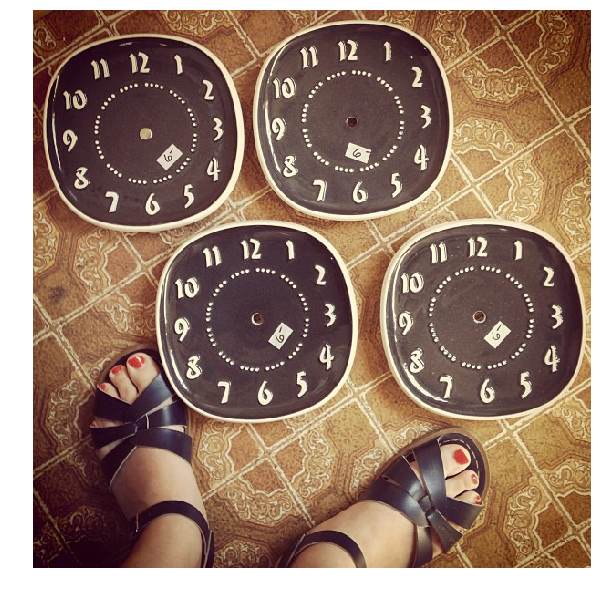

In [16]:
pick_row = 120
ic, ii_b  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]
for cap in query_by_id(df['cococapdf'], (ic, ii_b), 'caption'):
    print cap
plot_labelled_bb(get_image_filename(config, ic, ii_b), [])

<IPython.core.display.Latex object>

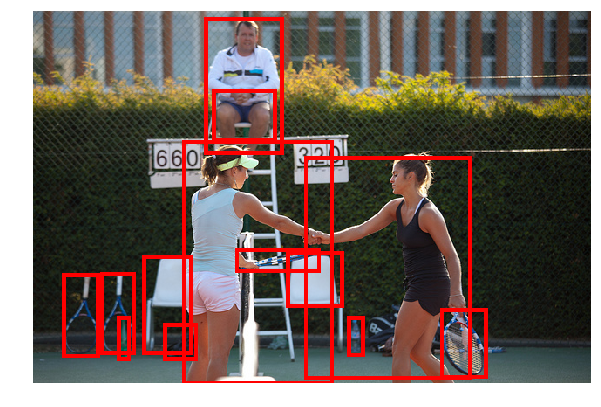

In [58]:
# load up one image from MSCOCO & overlay its bounding boxes and object IDs.
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), column=['bb', 'region_id']).values

display(Latex("$D = \\{" + ', '.join(['o_{' + str(rg) + '}' for _, rg in this_anno]) + "\\}$"))

plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, '') for b, reg in this_anno])

<IPython.core.display.Latex object>

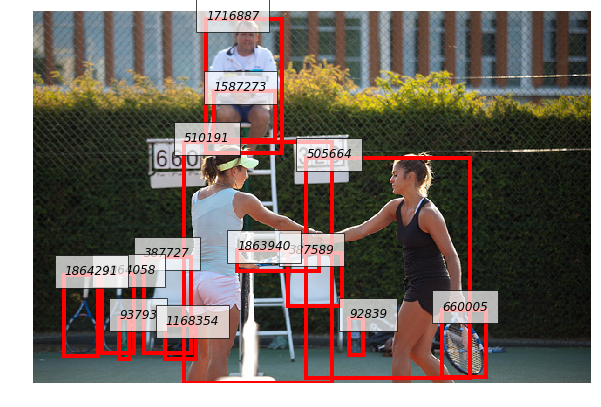

In [26]:
# load up one image from MSCOCO & overlay its bounding boxes and object IDs.
pick_row = 100
ic, ii  = df['refcoco_refdf'].iloc[pick_row][['i_corpus', 'image_id']]

this_anno = query_by_id(df['mscoco_bbdf'], (ic, ii), column=['bb', 'region_id']).values

display(Latex("$D = \\{" + ', '.join(['o_{' + str(rg) + '}' for _, rg in this_anno]) + "\\}$"))

plot_labelled_bb(get_image_filename(config, ic, ii),
                 [(b, str(reg)) for b, reg in this_anno])

In [68]:
def mask_background(imgid, bbs):
    img = plt.imread(get_image_filename(*imgid))
    mask = np.zeros_like(img)

    for (x, y, w, h) in bbs:
        mask[int(y):int(y+h), int(x):int(x+w),:] = 1

    masked_img = img * mask
    masked_img[masked_img == 0] = 255
    
    return masked_img

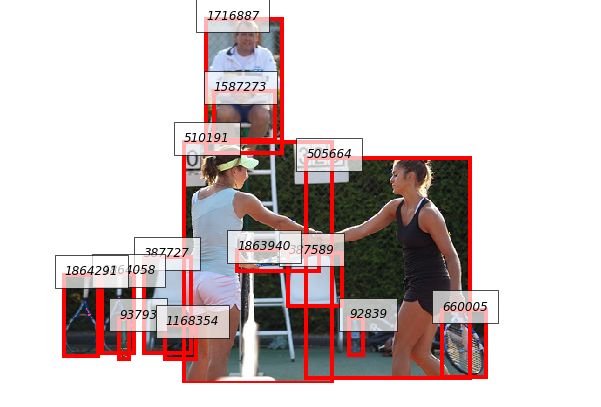

In [74]:
plot_labelled_bb(mask_background((config, ic, ii), [bb for bb, _ in this_anno]),
                 [(b, str(reg)) for b, reg in this_anno],
                 mode = 'img')

woman in white
female in white shorts and hat
blue shirt
lady in black on right
girl in black
woman in black
player in light clothes
white player
woman in white shorts
black shirt
girl in black
player in black
woman in black tank top and shorts holding tennis racket
woman in black outfit shacking other tennis player hand
a woman in white shorts
a woman in a visor shaking hands with a woman in black


,region_id,refexp
98,510191,woman in white
99,510191,female in white shorts and hat
100,510191,blue shirt
101,505664,lady in black on right
102,505664,girl in black
103,505664,woman in black
93,510191,player in light clothes
94,510191,white player
95,510191,woman in white shorts
96,505664,black shirt


<IPython.core.display.Latex object>

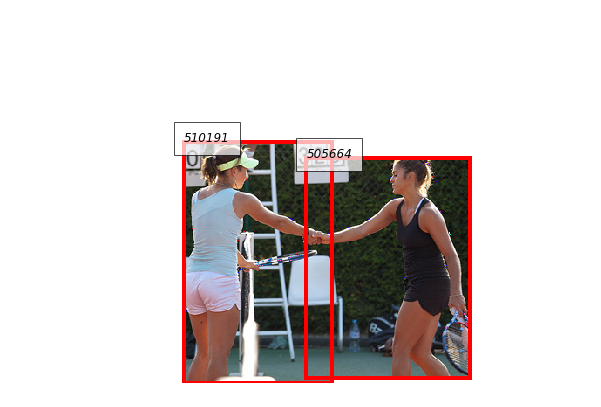

In [76]:
# get denotation of "woman" from referring expressions for this image
outcols = 'i_corpus image_id region_id refexp'.split()
combined = pd.concat([query_by_id(df['refcoco_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['refcocoplus_refdf'], (ic, ii), column=outcols),
                      query_by_id(df['grex_refdf'], (ic, ii), column=outcols)])
for refexp in combined['refexp'].values:
    print refexp
display(combined[['region_id', 'refexp']])
i_woman = [r for c,i,r in create_word2den(combined)['woman']]
display(Latex('$I(woman) = \\{' + ', '.join(['o_{' + str(i) + '}' for i in i_woman]) + '\\}$'))

woman_bbs = [(b, str(reg)) for b, reg in this_anno if reg in i_woman]

plot_labelled_bb(mask_background((config, ic, ii), [bb for bb, _ in woman_bbs]),
                 woman_bbs, mode='img')